**Predicting Relapse for Myocardial Infarction Patients**
-
**Roshan S. Parikh**

This is the code file for the project that includes all steps of the ML pipeline except for EDA, which can also be found in the GitHub repository for this project.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import math
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import pickle
from sklearn.inspection import permutation_importance
import shap

**LOADING DATA**

In [2]:
'''
Loading the data from UCI repository.
''' 

from ucimlrepo import fetch_ucirepo 
pd.set_option('display.max_rows', None)
  
# fetch dataset 
myocardial_infarction_complications = fetch_ucirepo(id=579) 
  
# data (as pandas dataframes) 
df = myocardial_infarction_complications.data.original 
X_full = myocardial_infarction_complications.data.features[:] 
y_full = myocardial_infarction_complications.data.targets[:] 
  
# metadata 
metadata = myocardial_infarction_complications.metadata
  
# variable information 
vars = myocardial_infarction_complications.variables

In [3]:
''' 
Reconfigure data for our purpose.
- Make X feature matrix
- Pick target variable to be Pulmonary Edema (OTEK_LANC)
'''
X = X_full[:]
y = y_full['REC_IM']

**MISSING VALUES**

In [4]:
pd.set_option('display.max_rows', 10)  # or use a specific number

X_nan_number = X.isna().sum().sort_values(ascending=False)
X_nan_percentage = X_nan_number/1700

print(X_nan_percentage>0.5)

missing_rows = X[X.isnull()]
print(missing_rows.shape) # Every row has at least one missing value

KFK_BLOOD      True
IBS_NASL       True
S_AD_KBRIG     True
D_AD_KBRIG     True
NOT_NA_KB     False
              ...  
zab_leg_04    False
NA_R_1_n      False
INF_ANAM      False
IM_PG_P       False
SEX           False
Length: 111, dtype: bool
(1700, 111)


In [5]:
'''
Dropping columns with >50% NaNs.
'''
X = X.drop(['KFK_BLOOD', 'IBS_NASL', 'D_AD_KBRIG', 'S_AD_KBRIG'], axis=1)

In [6]:
''' 
Dropping rows where 'AGE' are NaN.
'''

for ftr in ['AGE']:
    valid_index = X[X[ftr].notna()].index
    X = X.loc[valid_index]
    y = y.loc[valid_index]

In [7]:
X.shape

(1692, 107)

**ORGANIZING DATA**

In [8]:
''' 
Organizing data for later use.
- Four types provided in dataset information: binary, categorical, integer, continuous
'''
names_binary_feats = np.array(vars[(vars['type']=='Binary') & (vars['role']=='Feature')].name)
names_cat_feats = np.array(vars[(vars['type']=='Categorical') & (vars['role']=='Feature')].name)
names_int_feats = np.array(vars[(vars['type']=='Integer') & (vars['role']=='Feature')].name)
names_cont_feats = np.array(vars[(vars['type']=='Continuous') & (vars['role']=='Feature')].name)

# Adjusting for already-removed columns
names_cont_feats = np.setdiff1d(names_cont_feats, ['KFK_BLOOD'])
names_binary_feats = np.setdiff1d(names_binary_feats, ['IBS_NASL'])

# Change to data types appropriate for encoding/preprocessing
onehot_ftrs = np.concatenate((names_binary_feats, ['ant_im', 'lat_im', 'inf_im', 'post_im']))
ordinal_ftrs = np.concatenate((np.setdiff1d(names_cat_feats, ['ant_im', 'lat_im', 'inf_im', 'post_im']), ['NA_R_1_n', 'NA_R_2_n', 'NA_R_3_n', 'NOT_NA_2_n', 'NOT_NA_3_n'])) # note: ordinal features are already in order in the given dataset
minmax_ftrs = np.array(['AGE', 'S_AD_ORIT', 'D_AD_ORIT'])
std_ftrs = names_cont_feats

# Combine all feature arrays into one
all_ftrs = np.concatenate((onehot_ftrs, ordinal_ftrs, minmax_ftrs, std_ftrs))

# Change 'nan' string into NaN value
X[ordinal_ftrs] = X[ordinal_ftrs].astype(str)
X[onehot_ftrs] = X[onehot_ftrs].astype(str)
X.replace('nan', np.nan, inplace=True)


#for later use
with open('ordinal_ftrs.pkl', 'wb') as f:
    pickle.dump(ordinal_ftrs, f)

with open('onehot_ftrs.pkl', 'wb') as f:
    pickle.dump(onehot_ftrs, f)

**SPLITTING DATA**

In [9]:
''' 
Using Stratified k-Folds
- Notice that dataset is imbalanced
- Will be redone in pipeline, but this is just to make sure the stratified K folds works as expected
'''
print(f"balance (percentage): {y.value_counts()/(len(y))}") # 90.6% of patients are in class 0, while 9.4% are in class 1 ==> imbalanced data

random_state = 2

# Stratify-split out test data: 20% of data for testing
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,stratify=y,random_state=random_state)
print(f"test data \n{np.unique(y_test,return_counts=True)}")

splits = {}

# StratifiedKFold for validation-training splits with 3 splits
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
for fold_idx, (train_index, val_index) in enumerate(kf.split(X_other, y_other)):
    print(f'Fold {fold_idx + 1}')
    
    # Create training and validation splits
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]

    # Store current fold in the splits dictionary
    splits[f'fold_{fold_idx}'] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val
    }

    print(np.unique(y_train, return_counts=True))
    print(np.unique(y_val, return_counts=True))


balance (percentage): REC_IM
0    0.906028
1    0.093972
Name: count, dtype: float64
test data 
(array([0, 1]), array([307,  32]))
Fold 1
(array([0, 1]), array([817,  85]))
(array([0, 1]), array([409,  42]))
Fold 2
(array([0, 1]), array([817,  85]))
(array([0, 1]), array([409,  42]))
Fold 3
(array([0, 1]), array([818,  84]))
(array([0, 1]), array([408,  43]))


**PREPROCESSING: FEATURE ENCODING**

In [10]:
''' 
Creating and collecting encoders
- For categorical and ordinal data, treat missing data as its own category
- Will be done in pipeline again, but this is done to prepare for feature analyses
'''
from sklearn.impute import SimpleImputer

# Categorical
one_hot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# Ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=-1))])

# MinMax 
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler())])

# Standard scaler 
std_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std', std_transformer, std_ftrs),
        ('ohot', one_hot_transformer, onehot_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('minmax', minmax_transformer, minmax_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])
final_scaler = StandardScaler()

In [11]:
''' 
Preprocessing data for each split.
'''
X_splits_prep = {}

for key,value in splits.items():
    # Get data
    X_train = value['X_train']
    X_val = value['X_val']

    # Get preprocessed data
    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)

    # Standard scale everything
    X_train_prep = final_scaler.fit_transform(X_train_prep)
    X_val_prep = final_scaler.transform(X_val_prep)
    X_test_prep = final_scaler.transform(X_test_prep)

    # Turn into dfs
    X_train_df = pd.DataFrame(X_train_prep, columns = preprocessor.get_feature_names_out())
    X_val_df = pd.DataFrame(X_val_prep, columns = preprocessor.get_feature_names_out())
    X_test_df = pd.DataFrame(X_test_prep, columns = preprocessor.get_feature_names_out())
    
    # Store in dictionary splits_prep
    X_splits_prep[key] = {
        'X_train_df': X_train_df,
        'X_val_df': X_val_df,
        'X_test_df': X_test_df
    }

In [12]:
X_splits_prep['fold_0']['X_train_df'].shape

(902, 274)

**PREPROCESSING: FEATURE SELECTION AND CORRELATION TESTS**

In [13]:
''' 
Pearson Correlations
'''
pd.set_option('display.max_rows', 200)  # or use a specific number

# Use fold_0 to see Pearson Correlations
X_filtered = X_splits_prep['fold_0']['X_train_df']

mat = X_filtered.corr(method='pearson', min_periods=1, numeric_only=False)

# Set a threshhold for correlation values
threshold = 0.9

# Get the pairs of features that meet the criteria
mask = (mat > threshold) & (mat != 1)  # Exclude self-correlation
high_corr_pairs = mat[mask]

# Convert to a long format for easier reading
high_corr_pairs = high_corr_pairs.stack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Get rid of reverse-order pairs of (Feature1, Feature2)
high_corr_pairs['Sorted_Pair'] = high_corr_pairs.apply(
    lambda row: tuple(sorted([row['Feature1'], row['Feature2']])), axis=1)

high_corr_pairs_unique = high_corr_pairs.drop_duplicates(subset='Sorted_Pair')
high_corr_pairs_unique = high_corr_pairs_unique.drop(columns=['Sorted_Pair'])

sorted_pairs = high_corr_pairs_unique.sort_values(by='Correlation', ascending=False)

# Display the sorted DataFrame with descriptions
print(sorted_pairs) #went through the pairs; don't feel comfortable removing anything 


                       Feature1                    Feature2  Correlation
1        ohot__GIPER_NA_missing        ohot__GIPO_K_missing     0.983618
87   ohot__n_p_ecg_p_07_missing  ohot__n_r_ecg_p_10_missing     0.981741
86   ohot__n_p_ecg_p_07_missing  ohot__n_r_ecg_p_09_missing     0.981741
85   ohot__n_p_ecg_p_07_missing  ohot__n_r_ecg_p_08_missing     0.981741
84   ohot__n_p_ecg_p_07_missing  ohot__n_r_ecg_p_06_missing     0.981741
83   ohot__n_p_ecg_p_07_missing  ohot__n_r_ecg_p_05_missing     0.981741
82   ohot__n_p_ecg_p_07_missing  ohot__n_r_ecg_p_04_missing     0.981741
81   ohot__n_p_ecg_p_07_missing  ohot__n_r_ecg_p_03_missing     0.981741
80   ohot__n_p_ecg_p_07_missing  ohot__n_r_ecg_p_02_missing     0.981741
79   ohot__n_p_ecg_p_07_missing  ohot__n_r_ecg_p_01_missing     0.981741
78   ohot__n_p_ecg_p_06_missing  ohot__n_r_ecg_p_10_missing     0.981741
77   ohot__n_p_ecg_p_06_missing  ohot__n_r_ecg_p_09_missing     0.981741
95   ohot__n_p_ecg_p_08_missing  ohot__n_r_ecg_p_01

61.94269331334118


/tmp/ipykernel_2501478/1955856902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_oh_ord.fillna(-1, inplace=True)


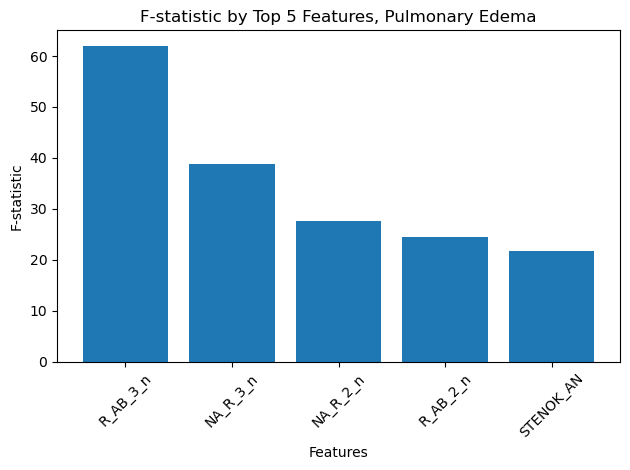

In [14]:
'''
f-tests for classification problems (linear correlations)
'''

from sklearn.feature_selection import f_classif, mutual_info_classif

X_oh_ord = X[np.concatenate([onehot_ftrs,ordinal_ftrs])] #only onehot and ordinal ftrs because no nans
X_oh_ord.fillna(-1, inplace=True)

f_stats, p_values = f_classif(X_oh_ord, y)
lin_corr = pd.Series(f_stats, index = X_oh_ord.columns).sort_values(ascending=False)

Xf = lin_corr.head(5).index
Yf = lin_corr.head(5).values
print(max(Yf))

plt.bar(Xf, Yf)
figsize = (4,3)
plt.title(f'F-statistic by Top 5 Features, Pulmonary Edema')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.tight_layout()
plt.show()

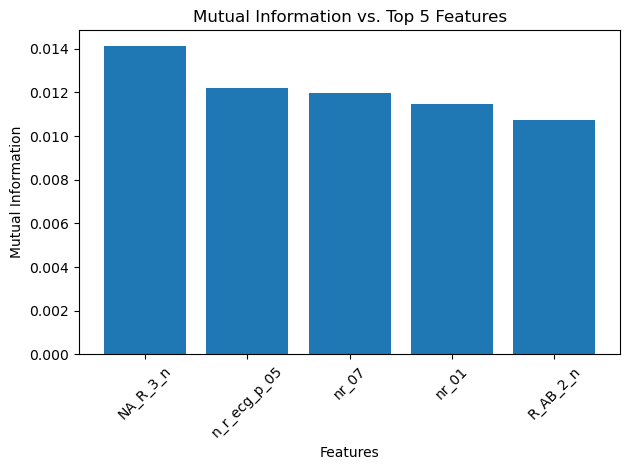

In [15]:
''' 
MI test for classification (non-linear correlations)
'''
mc = mutual_info_classif(X_oh_ord, y)
non_lin_corr = pd.Series(mc, X_oh_ord.columns).sort_values(ascending=False)

Xm = non_lin_corr.head(5).index
Ym = non_lin_corr.head(5).values

plt.bar(Xm, Ym)
figsize=(4,3)
plt.title(f'Mutual Information vs. Top 5 Features')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()

**MULTIPLE MODEL GRID CV**
- Logistic regression (Ridge/L2)
- K-nearest neighbors
- Support Vector Classifier (Linear)
- Support Vector Classifier (RBF)
- XGBoost

In [16]:
''' 
Preparing for splitting.
- X, y are already defined and cleaned
- Continuous features with NaNs: 'S_AD_ORIT', 'D_AD_ORIT', 'L_BLOOD', 'NA_BLOOD', 'K_BLOOD', 'AST_BLOOD', 'ALT_BLOOD', 'ROE'
'''
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Removing continuous columns with NaNs

# Categorical
one_hot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# Ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=-1))])

# MinMax 
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler())])

# Standard scaler 
std_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std', std_transformer, std_ftrs),
        ('ohot', one_hot_transformer, onehot_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('minmax', minmax_transformer, minmax_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])
with open('clf.pkl', 'wb') as f:
    pickle.dump(clf, f)



In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, fbeta_score


def MLpipe_StratKFold(X, y, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies StratifiedKFold with 4 folds to other.
    The accuracy is minimized in cross-validation.

    1. Loop through  different 5 random states
    2. Split your data 
    3. Fit a model using GridSearchCV with KFold and the predefined Preprocessor 
    4. Calculate the model's error on the test set 
    5. Return a list of 5 test scores and 5 best models 
    '''
    
    # Results dictionary to be returned
    results = {}
    baseline_accuracy = []

    for i in range(5):
        iterative_imputer = IterativeImputer(max_iter=10, random_state=42*i)

        # Split Data
        X_other, X_test, y_other, y_test = train_test_split(X,y, train_size=0.8,random_state = 42*i)

        majority_class = np.bincount(y_test).argmax()
        y_baseline = [majority_class] * len(y_test)
        baseline_accuracy.append(accuracy_score(y_test, y_baseline))

        # K-folds
        kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42*i)

        if model != 'XGB':
            pipe = make_pipeline(preprocessor, iterative_imputer, StandardScaler(),ML_algo)
        else:
            pipe = make_pipeline(preprocessor, StandardScaler(),ML_algo)

        # CV and prepro
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(f1_score),
                                cv=kf, return_train_score = True, n_jobs=-1, verbose=False)

        grid.fit(X_other, y_other)
        y_pred = grid.best_estimator_.predict(X_test)

        transformer = grid.best_estimator_['columntransformer']
        X_test_prep = transformer.transform(X_test)
        X_test_prep_df = pd.DataFrame(X_test_prep, columns = transformer.get_feature_names_out())

        results[i] = {
            'X_test [not preprocessed]': X_test,
            'X_test [preprocessed]': X_test_prep_df,
            'y_test': y_test,
            'y_pred': y_pred,
            'test_score': accuracy_score(y_test, y_pred),
            'f_1_score': fbeta_score(y_test, y_pred, beta=1),
            'recall': recall_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'best_model': grid.best_estimator_,
            'best_params': grid.best_params_
        }

    results['baseline_accuracy'] = {
        'baseline_avg': np.mean(baseline_accuracy),
        'baseline_std': np.std(baseline_accuracy)
    }

    baseline = results['baseline_accuracy']['baseline_avg']

    for i in range(5):
        results[i]['relative_improvement'] = (results[i]['test_score'] - baseline)/baseline

    return results

In [18]:
''' 
Defining parameters.
'''
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

random_state = 42; max_iter = 1000000

models_and_params = {
    'Ridge': {'model': LogisticRegression(penalty = 'l2', random_state=random_state, max_iter=max_iter),
              'params': {'logisticregression__C': np.logspace(-8, 3, 12),
                         'logisticregression__class_weight': ['balanced', None]}
    },
    'KNN': {'model': KNeighborsClassifier(),
            'params': {'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15, 30, 50, 70, 100],
                       'kneighborsclassifier__weights': ['uniform', 'distance'],
                       'kneighborsclassifier__p': [1,2]} #1 is Manhattan distance, 2 is Euclidean distance 
    },
    'SVC Linear': {'model': SVC(kernel = 'linear', random_state=random_state),
                   'params': {'svc__C': np.logspace(-5, 3, 9),
                              'svc__class_weight': ['balanced', None]}
    },
    'SVC RBF': {'model': SVC(kernel = 'rbf', random_state=random_state),
                'params': {'svc__C': np.logspace(-5, 3, 9),
                           'svc__class_weight': ['balanced', None]}
    }, 
    'XGB': {'model': XGBClassifier(learning_rate = 0.03, n_estimators = 1000, missing=np.nan, subsample=0.66),
            'params': {'xgbclassifier__max_depth': [1, 3, 10, 30, 100],  # Depth of the tree
                       'xgbclassifier__colsample_bytree': [0.1, 0.25, 0.5, 0.75, 1.0],  # Fraction of features used for fitting trees
                       'xgbclassifier__scale_pos_weight': [0.025, 0.05, 0.1, 0.25, 0.5, 1, 5, 10]}
    }
}



In [19]:
'''
Performing grid search.
'''
models = ['XGB', 'KNN', 'Ridge', 'SVC Linear', 'SVC RBF']

model_results = {}

for model in models:
    ML_algo = models_and_params[model]['model']
    params = models_and_params[model]['params']
    
    print(f"Results for {model}")
    results = MLpipe_StratKFold(X, y, preprocessor=preprocessor, ML_algo=ML_algo, param_grid=params)

    # To print for each random_state
    scores = []
    for i in range(5):
        print(f"Results for Random State {i}")
        print(f"  Test Score: {results[i]['test_score']}")
        print(f"  f1 Score: {results[i]['f_1_score']}")
        print(f"    precision: {results[i]['precision']}")
        print(f"    recall: {results[i]['recall']}")
        print(f"  Baseline: {results['baseline_accuracy']['baseline_avg']}, Relative Accuracy: {results[i]['relative_improvement']}")
        print(f"  Baseline Standard Deviation: {results['baseline_accuracy']['baseline_std']}")
        print(f"  Best Params: {results[i]['best_params']}")
        scores.append(results[i]['test_score'])

    print(f"Mean of Test Scores: {np.mean(scores)}")
    print(f"Standard Deviation of Test Scores: {np.std(scores)}")
    print("=========")

    model_results[model] = results

# Save entire dictionary as pickle
import pickle 

with open('model_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

Results for XGB


Results for Random State 0
  Test Score: 0.7374631268436578
  f1 Score: 0.25210084033613445
    precision: 0.15625
    recall: 0.6521739130434783
  Baseline: 0.9144542772861357, Relative Accuracy: -0.19354838709677424
  Baseline Standard Deviation: 0.014085352668216346
  Best Params: {'xgbclassifier__colsample_bytree': 0.1, 'xgbclassifier__max_depth': 1, 'xgbclassifier__scale_pos_weight': 10}
Results for Random State 1
  Test Score: 0.8643067846607669
  f1 Score: 0.30303030303030304
    precision: 0.25
    recall: 0.38461538461538464
  Baseline: 0.9144542772861357, Relative Accuracy: -0.0548387096774194
  Baseline Standard Deviation: 0.014085352668216346
  Best Params: {'xgbclassifier__colsample_bytree': 0.1, 'xgbclassifier__max_depth': 1, 'xgbclassifier__scale_pos_weight': 5}
Results for Random State 2
  Test Score: 0.8230088495575221
  f1 Score: 0.25
    precision: 0.2127659574468085
    recall: 0.30303030303030304
  Baseline: 0.9144542772861357, Relative Accuracy: -0.100000000000000

/users/rparik14/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/users/rparik14/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/users/rparik14/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/users/rparik14/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were gi

Results for Random State 0
  Test Score: 0.911504424778761
  f1 Score: 0.0625
    precision: 0.1111111111111111
    recall: 0.043478260869565216
  Baseline: 0.9144542772861357, Relative Accuracy: -0.0032258064516129488
  Baseline Standard Deviation: 0.014085352668216346
  Best Params: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
Results for Random State 1
  Test Score: 0.8967551622418879
  f1 Score: 0.05405405405405406
    precision: 0.09090909090909091
    recall: 0.038461538461538464
  Baseline: 0.9144542772861357, Relative Accuracy: -0.019354838709677448
  Baseline Standard Deviation: 0.014085352668216346
  Best Params: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
Results for Random State 2
  Test Score: 0.8997050147492626
  f1 Score: 0.0
    precision: 0.0
    recall: 0.0
  Baseline: 0.9144542772861357, Relative Accuracy: -0.016129032258064502


/users/rparik14/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Results for Random State 0
  Test Score: 0.7699115044247787
  f1 Score: 0.22
    precision: 0.14285714285714285
    recall: 0.4782608695652174
  Baseline: 0.9144542772861357, Relative Accuracy: -0.1580645161290323
  Baseline Standard Deviation: 0.014085352668216346
  Best Params: {'svc__C': 1.0, 'svc__class_weight': 'balanced'}
Results for Random State 1
  Test Score: 0.7109144542772862
  f1 Score: 0.20967741935483872
    precision: 0.1326530612244898
    recall: 0.5
  Baseline: 0.9144542772861357, Relative Accuracy: -0.2225806451612903
  Baseline Standard Deviation: 0.014085352668216346
  Best Params: {'svc__C': 0.09999999999999999, 'svc__class_weight': 'balanced'}
Results for Random State 2
  Test Score: 0.7728613569321534
  f1 Score: 0.17204301075268819
    precision: 0.13333333333333333
    recall: 0.24242424242424243
  Baseline: 0.9144542772861357, Relative Accuracy: -0.15483870967741936
  Baseline Standard Deviation: 0.014085352668216346
  Best Params: {'svc__C': 1.0, 'svc__class

In [5]:
''' 
Computing baseline f1 score.
'''
from sklearn.metrics import fbeta_score

f1 = []
for i in range(5):
    y_test = pd.read_csv(f'XGB_y_test_{i}.csv') # test sets are model agnostic. every model's test set will be the same for the same i
    y_0 = np.ones_like(y_test)
    f1.append(fbeta_score(y_test, y_0, beta=1))

print(np.mean(f1))
print(np.std(f1))

0.1572995830148689
0.02382399791414916


In [1]:
import pickle
with open('model_results.pkl', 'rb') as f:
    model_results = pickle.load(f)

In [27]:
''' 
Saving models and data.
'''

for model in ['Ridge', 'KNN', 'SVC Linear','SVC RBF', 'XGB']:
    for i in range(5):
        # Save test sets as CSV
        X_test_tbs = model_results[model][i]['X_test [not preprocessed]']
        X_test_prep_tbs = model_results[model][i]['X_test [preprocessed]']
        y_test_tbs = model_results[model][i]['y_test'].reset_index(drop=True)

        X_test_tbs.to_csv(f'{model}_X_test_{i}.csv', index=False)

        X_test_prep_tbs.to_csv(f'{model}_X_test_prep_{i}.csv', index=False)

        y_test_tbs_df = pd.DataFrame(y_test_tbs.values, columns=['y_test'])
        y_test_tbs_df.to_csv(f'{model}_y_test_{i}.csv', index=False)

        # Save models
        mymodel = model_results[model][i]['best_model'][-1]
        with open(f'{model}_{i}_trained', 'wb') as f:
            pickle.dump(mymodel, f)

**RESULTS**

In [2]:
'''
Loading data
'''
import pickle
with open(f"model_results.pkl", 'rb') as file:
        model_results = pickle.load(file)


In [34]:
''' 
Average and Std of Test Scores for all models.
''' 
model_test_scores = {}
model_f1_scores = {}

for model in ['Ridge', 'KNN', 'SVC Linear', 'SVC RBF', 'XGB']:
    test_scores = []
    f1_scores = []

    mymodel = model_results[model]
    for i in range(5):
        test_scores.append(mymodel[i]['relative_improvement'])
        f1_scores.append(mymodel[i]['f_1_score'])
    model_test_scores[model] = {
        'average': np.mean(test_scores),
        'std': np.std(test_scores)
    }

    model_f1_scores[model] = {
        'average': np.mean(f1_scores),
        'std': np.std(f1_scores)
    }
    

In [35]:
# Getting average and std for accuracy and f1 scores
print(f"accuracy {model_test_scores}")
print(f"f1 scores {model_f1_scores}")

accuracy {'Ridge': {'average': -0.22451612903225807, 'std': 0.016397761325340418}, 'KNN': {'average': -0.015483870967741958, 'std': 0.011965959349026702}, 'SVC Linear': {'average': -0.22838709677419353, 'std': 0.020845799253423895}, 'SVC RBF': {'average': -0.15548387096774197, 'std': 0.04286318772096281}, 'XGB': {'average': -0.16193548387096782, 'std': 0.07382517245092589}}
f1 scores {'Ridge': {'average': 0.22597827931527076, 'std': 0.019453965913842325}, 'KNN': {'average': 0.023310810810810812, 'std': 0.02867445293773371}, 'SVC Linear': {'average': 0.21222683736440356, 'std': 0.026281635754569457}, 'SVC RBF': {'average': 0.2282478660902339, 'std': 0.05495739261810295}, 'XGB': {'average': 0.2462114138584727, 'std': 0.035547849014708796}}


In [36]:
''' 
Model with best f1 score on average: XGB
Single model with best f1 score: SVC RBF 4
Single XGB model with best f1 score: XGB 1

Single model with the best accuracy:
'''

for model in ['Ridge', 'KNN', 'SVC Linear', 'SVC RBF', 'XGB']:
    print(model)
    byf1 = []
    byacc = []
    for i in range(5):
        byf1.append(model_results[model][i]['f_1_score'])
        byacc.append(model_results[model][i]['relative_improvement'])
    
    bestf1idx = np.argmax(byf1)
    bestaccidx=np.argmax(byacc)

    print(f"{bestf1idx}. best f1 score: {np.max(byf1)}, params: {model_results[model][bestf1idx]['best_params']}")
    print(f"{bestaccidx}. best acc: {np.max(byacc)}, params: {model_results[model][bestaccidx]['best_params']}")


Ridge
1. best f1 score: 0.25, params: {'logisticregression__C': 0.01, 'logisticregression__class_weight': 'balanced'}
4. best acc: -0.2, params: {'logisticregression__C': 0.01, 'logisticregression__class_weight': 'balanced'}
KNN
0. best f1 score: 0.0625, params: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
0. best acc: -0.0032258064516129488, params: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
SVC Linear
4. best f1 score: 0.25196850393700787, params: {'svc__C': 0.001, 'svc__class_weight': 'balanced'}
1. best acc: -0.20322580645161298, params: {'svc__C': 0.001, 'svc__class_weight': 'balanced'}
SVC RBF
4. best f1 score: 0.3333333333333333, params: {'svc__C': 1.0, 'svc__class_weight': 'balanced'}
4. best acc: -0.0870967741935484, params: {'svc__C': 1.0, 'svc__class_weight': 'balanced'}
XGB
1. best f1 score: 0.30303030303030304, params: {'xgbclassifie

Confusion Matrix
[[283  30]
 [ 16  10]]


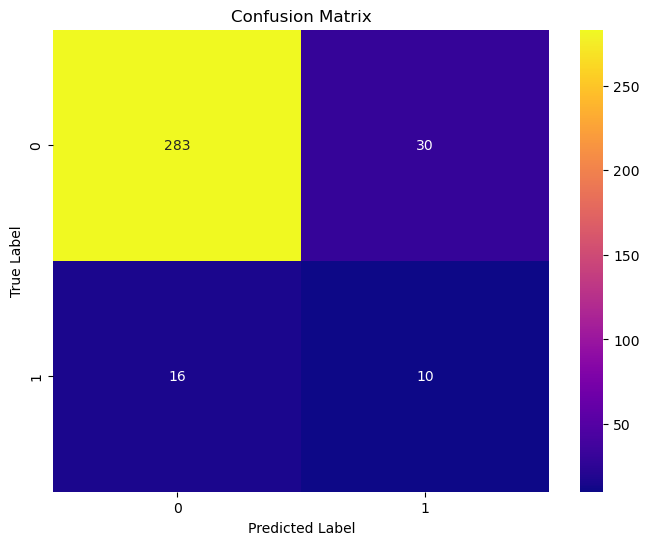

In [37]:
'''
Confusion Matrix for XGB model with best f1 score
'''
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model_results['XGB'][1]['y_pred']
y_test = model_results['XGB'][1]['y_test']

cm = confusion_matrix(y_test, y_pred)


print("Confusion Matrix")
print(cm)

# Optional: Visualize the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="plasma", xticklabels=[0,1], yticklabels=[0,1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('confusion_matrix.png', dpi = 300)
plt.show()

**INTERPRETABILITY: XGBoost Model**

GLOBAL: BUILT IN METRICS

In [38]:
''' 
Best model by average f1 score: XGBoost_1
''' 
with open(f"XGB_1_trained", 'rb') as file:
    # Load the object from the file
    XGBModel = pickle.load(file)

X_test = pd.read_csv('XGB_X_test_prep_1.csv')

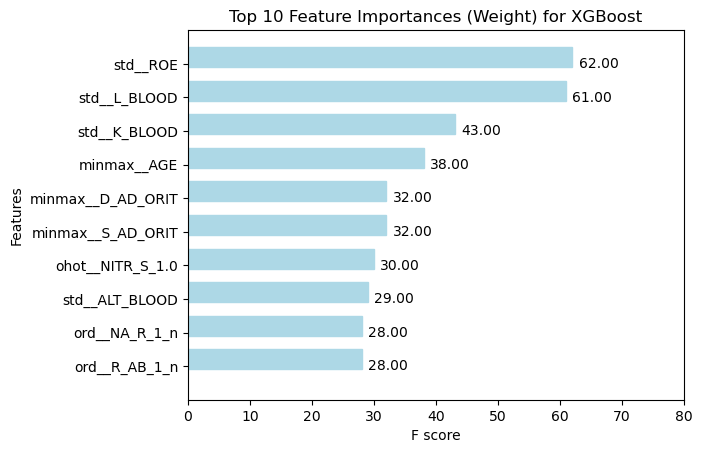

In [39]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import xgboost as xgb

ax = xgb.plot_importance(XGBModel, importance_type='weight', max_num_features=10, values_format='{v:.2f}')
plt.title('Top 10 Feature Importances (Weight) for XGBoost')
indices = [5, 3, 2, 276, 278, 277, 49, 0, 271, 265][::-1]
feature_names = X_test.columns[indices].tolist()
plt.yticks(ticks=range(len(feature_names)), labels=feature_names)
plt.xlim(0, 80)
plt.grid(False)
for bar in ax.patches:
    bar.set_height(bar.get_height() * 3)  
    bar.set_color('lightblue') 
plt.tight_layout
plt.savefig(f'xgb_importance_weight_1.png', dpi=300, bbox_inches='tight')
plt.show()


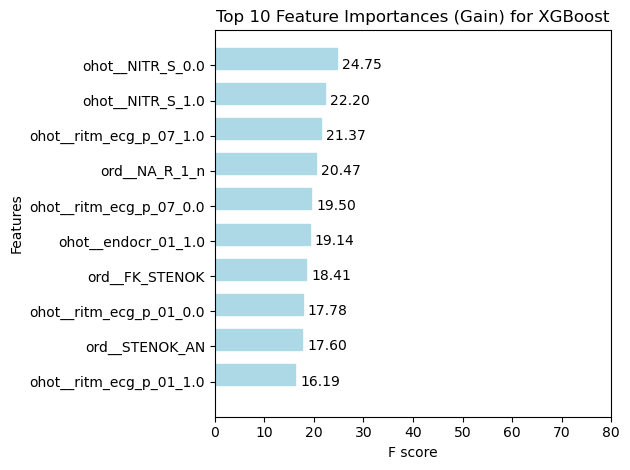

In [40]:
ax = xgb.plot_importance(XGBModel, importance_type='gain', max_num_features=10, values_format='{v:.2f}')
plt.title('Top 10 Feature Importances (Gain) for XGBoost')
indices = [48,49,215,271,214,72,260,202,268,203][::-1]
feature_names = X_test.columns[indices].tolist()
plt.yticks(ticks=range(len(feature_names)), labels=feature_names)
plt.xlim(0, 80)
plt.grid(False)
for bar in ax.patches:
    bar.set_height(bar.get_height() * 3) 
    bar.set_color('lightblue') 
plt.tight_layout()
plt.savefig(f'xgb_importance_gain_1.png', dpi=300, bbox_inches='tight') 
plt.show()

GLOBAL IMPORTANCE: PERMUTATION TESTING

In [3]:
with open("model_results.pkl", 'rb') as file:
    model_results = pickle.load(file)

In [42]:
from sklearn.metrics import f1_score, make_scorer

def permutation_imps_xgb(i):
    with open(f"XGB_{i}_trained", 'rb') as file:
        # Load the object from the file
        trainedModel = pickle.load(file)
    
    X_test = pd.read_csv(f'XGB_X_test_prep_{i}.csv')
    y_test = pd.read_csv(f'XGB_y_test_{i}.csv')

    perm_imps = permutation_importance(trainedModel, X_test, y_test, n_repeats=5, random_state=42, scoring = make_scorer(f1_score))

    return perm_imps

xgb_perm_imps = permutation_imps_xgb(1)
print('XGB Done!')

XGB Done!


In [43]:
import pickle 

with open('xgb_permutation_importances.pkl', 'wb') as f:
            pickle.dump(xgb_perm_imps, f)

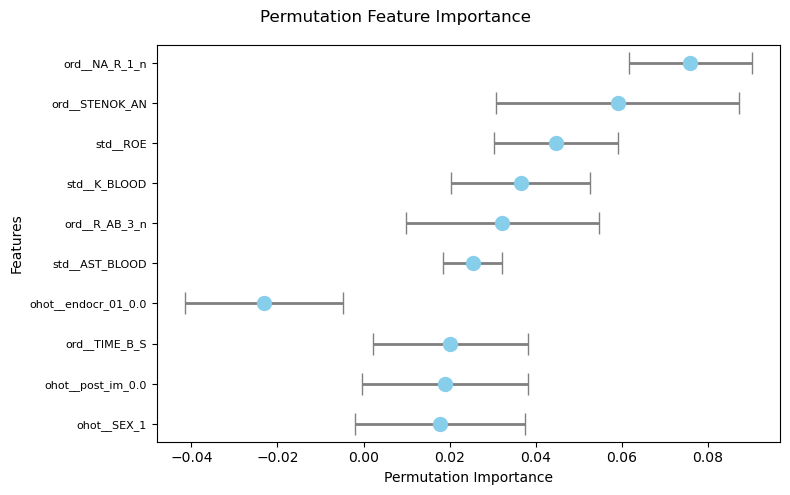

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))

means = xgb_perm_imps['importances_mean']
std = xgb_perm_imps['importances_std']

top10idx = np.argsort(np.abs(means))[::-1][:10]
top10means = means[top10idx]
top10std = std[top10idx]
top10ftrs = X_test.columns[top10idx]

plt.errorbar(top10means, range(10), xerr=top10std, fmt='o', color='skyblue', 
             ecolor='gray', elinewidth=2, capsize=8, markersize=10)

plt.yticks(range(10), top10ftrs, fontsize=8)
plt.ylabel('Features')
plt.xlabel("Permutation Importance")

plt.gca().invert_yaxis()

plt.suptitle("Permutation Feature Importance")

plt.tight_layout()
plt.savefig(f'xgb_perm_importance_1.png', dpi=300)
plt.show()


SHAP VALUES (GLOBAL)

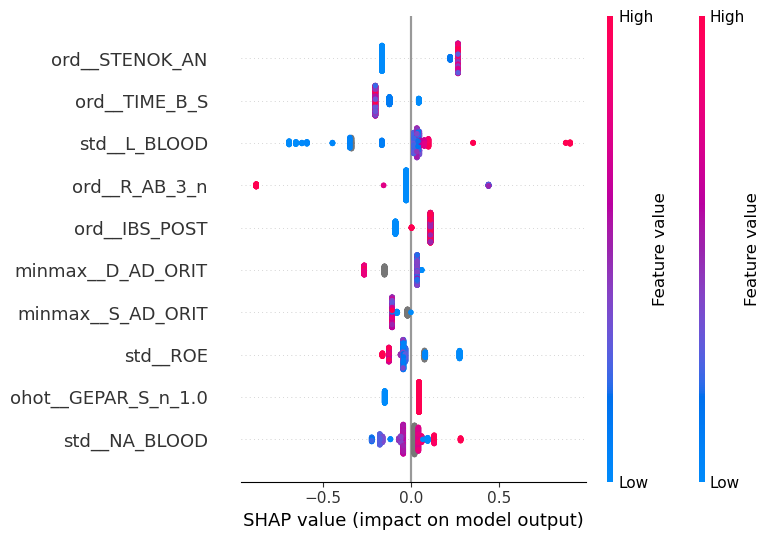

In [23]:
''' 
XGBoost 
''' 
import shap
import matplotlib.pyplot as plt
shap.initjs()

model = model_results['XGB'][1]['best_model'][-1]
X_test = pd.read_csv(f'XGB_X_test_prep_1.csv')
y_test = pd.read_csv(f'XGB_y_test_1.csv')
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=10)

SHAP VALUES (LOCAL)

In [7]:
''' 
Let's look at XGB. 
For random state 1 show the force plots for points 0 (class 0), 200 (class 0), 337 (class 1).
'''
shap.initjs()

model = model_results['XGB'][1]['best_model'][-1]
explainer = shap.TreeExplainer(model)

X_test = pd.read_csv(f'XGB_X_test_prep_1.csv')

shap.force_plot(explainer.expected_value[0], shap_values[0,:], features = X_test.iloc[0,:].round(3), matplotlib=True, show=False).savefig('xgb_local_shap_1_point0.png', dpi=300)


In [8]:
shap.force_plot(explainer.expected_value[0], shap_values[200,:], features = X_test.iloc[200,:].round(3), matplotlib=True, show=False).savefig('xgb_local_shap_1_point200.png', dpi=300)

In [10]:
shap.force_plot(explainer.expected_value[0], shap_values[337,:], features = X_test.iloc[337,:].round(3), matplotlib=True, show=False).savefig('xgb_local_shap_1_point337.png', dpi=300)